In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv, find_dotenv

In [2]:
# подгружаем .env
load_dotenv()

True

In [3]:
TABLE_NAME = "users_churn" # таблица с данными в postgres 

# Параметры для трекинга эксперимента
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_experiment_imartnv"
RUN_NAME = "eda"

# Директория для хранения артефактов
ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

# Настрофка отображения
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [4]:
# Подключение к базе и получение данных
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [5]:
df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,11532,0489-WMEMG,2018-03-01,NaT,One year,Yes,Electronic check,49.45,1119.35,DSL,No,No,No,Yes,No,No,Female,0,No,Yes,No,0
1,11534,7435-ZNUYY,2019-08-01,NaT,One year,No,Mailed check,20.60,116.60,None,None,None,None,None,None,None,Male,0,No,No,No,0


/tmp/ipykernel_3106/2453846404.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(agg_df[x], rotation=40)  # Используем данные из agg_df для меток
/tmp/ipykernel_3106/2453846404.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(agg_df[x], rotation=30)  # Используем данные из agg_df для меток
/tmp/ipykernel_3106/2453846404.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(agg_df[x], rotation=30)  # Используем данные из agg_df для меток


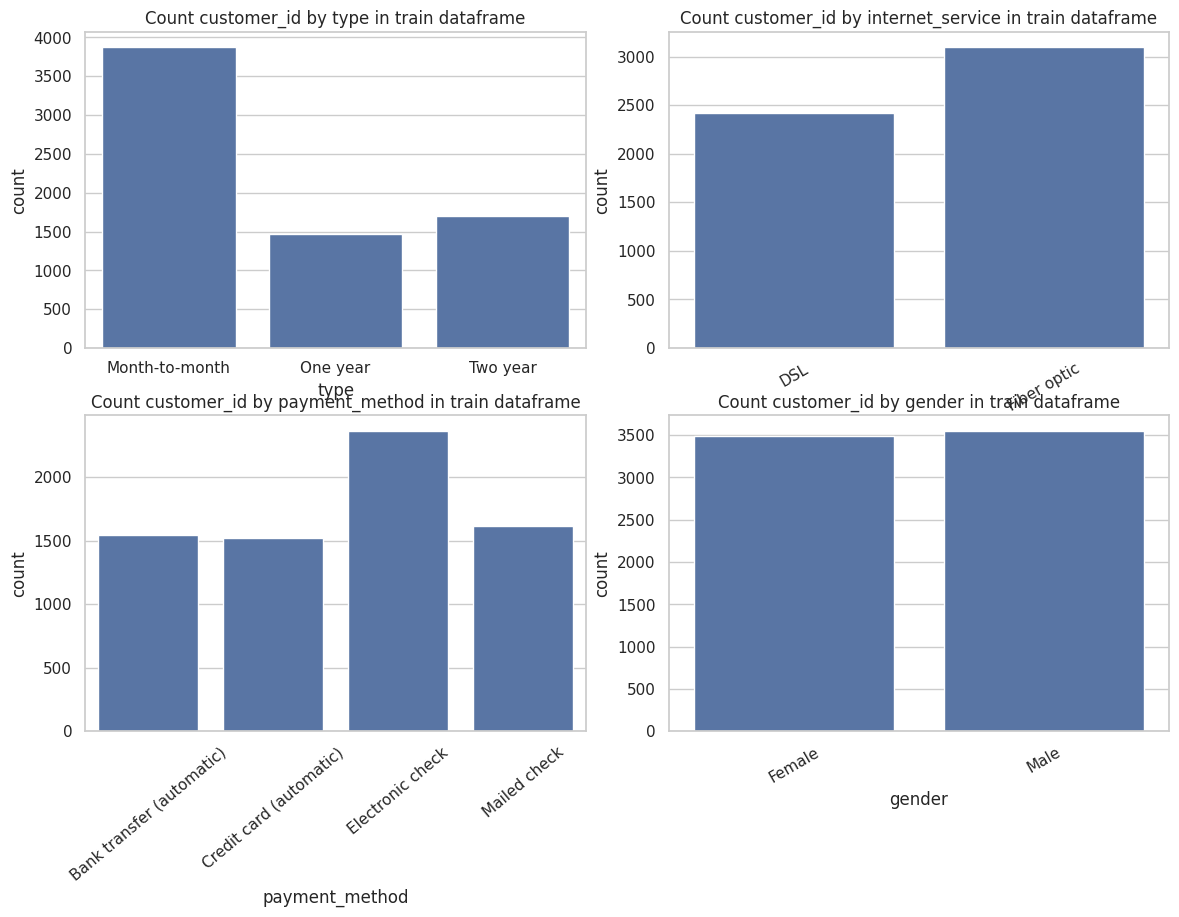

In [6]:
# Настройки для графиков
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.set_size_inches(12, 8, forward=True) 
fig.tight_layout(pad=2)

# Первый график
x = "type"
y = "customer_id"
stat = ["count"]

agg_df = df.groupby(x)[y].agg(stat).reset_index()

sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0]) 
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

# Второй график
x = "payment_method"
y = "customer_id"
stat = ["count"]

agg_df = df.groupby(x)[y].agg(stat).reset_index()

sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0]) 
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(agg_df[x], rotation=40)  # Используем данные из agg_df для меток


# Третий график
x = "internet_service"
y = "customer_id"
stat = ["count"]

agg_df = df.groupby(x)[y].agg(stat).reset_index()

sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1]) 
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(agg_df[x], rotation=30)  # Используем данные из agg_df для меток


# Чертвертый график
x = "gender"
y = "customer_id"
stat = ["count"]

agg_df = df.groupby(x)[y].agg(stat).reset_index()

sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1]) 
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_xticklabels(agg_df[x], rotation=30)  # Используем данные из agg_df для меток


plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoder = LabelEncoder()

In [8]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
    "multiple_lines",
    "paperless_billing"
]
stat = ["count"]

print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(5))

     online_security online_backup device_protection tech_support   
1                 No            No                No           No  \
0                 No            No                No           No   
3                 No            No                No           No   
1111             Yes           Yes               Yes          Yes   
53                No            No                No           No   

     streaming_tv streaming_movies  senior_citizen partner dependents   
1              No               No               0      No         No  \
0              No               No               0      No         No   
3              No               No               0      No         No   
1111          Yes              Yes               0     Yes        Yes   
53            Yes               No               0      No         No   

     multiple_lines paperless_billing  customer_id  
1                No               Yes          136  
0                No                No   

In [9]:
for column in binary_columns:
    df[column] = encoder.fit_transform(df[column].fillna("No"))

In [10]:
df.head()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,11532,0489-WMEMG,2018-03-01,NaT,One year,1,Electronic check,49.45,1119.35,DSL,0,0,0,1,0,0,Female,0,0,1,0,0
1,11534,7435-ZNUYY,2019-08-01,NaT,One year,0,Mailed check,20.60,116.60,None,0,0,0,0,0,0,Male,0,0,0,0,0
2,11536,1354-YZFNB,2019-10-01,NaT,Two year,0,Credit card (automatic),19.55,68.80,None,0,0,0,0,0,0,Male,0,1,1,0,0
3,11539,6956-SMUCM,2019-07-01,2019-10-01,Month-to-month,1,Credit card (automatic),99.00,287.40,Fiber optic,1,0,1,0,1,1,Female,0,0,0,0,1
4,11541,2985-FMWYF,2018-03-01,NaT,Month-to-month,1,Electronic check,93.50,2341.55,Fiber optic,0,0,0,0,1,1,Female,0,0,0,1,0


In [11]:
heart_map = df[binary_columns].apply(pd.Series.value_counts).T

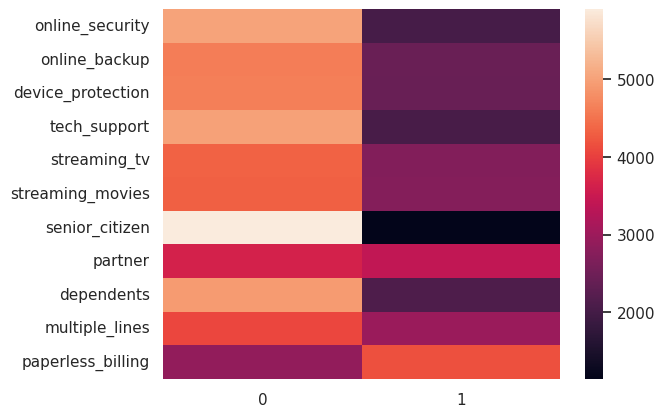

In [12]:
sns.heatmap(heart_map)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2'))

In [13]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

stats = ["mean", "median", lambda x: x.mode().iloc[0]]

charges_monthly_agg = df.groupby(x)['monthly_charges'].agg(stats).reset_index()
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

charges_total_agg = df.groupby(x)['total_charges'].agg(stats).reset_index()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

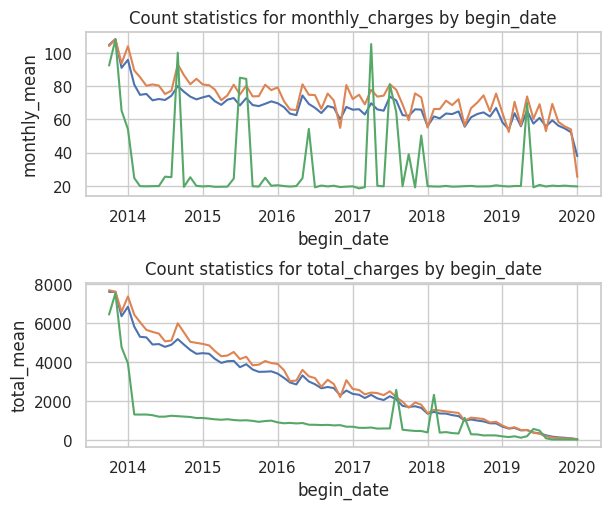

In [14]:
# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# Построение линейных графиков для ежемесячных платежей
for col in ["monthly_mean", "monthly_median", "monthly_mode"]:
    sns.lineplot(data=charges_monthly_agg, x=x, y=col, ax=axs[0])

# Установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# Построение линейных графиков для общих платежей
for col in ["total_mean", "total_median", "total_mode"]:
    sns.lineplot(data=charges_total_agg, x=x, y=col, ax=axs[1])

# Установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_3'))

In [15]:
x = 'target'
stats = ['nunique']

In [16]:
agg_df = df.groupby(x).agg(stats).reset_index().melt(id_vars=["target"], var_name="Feature", value_name="Unique Values")

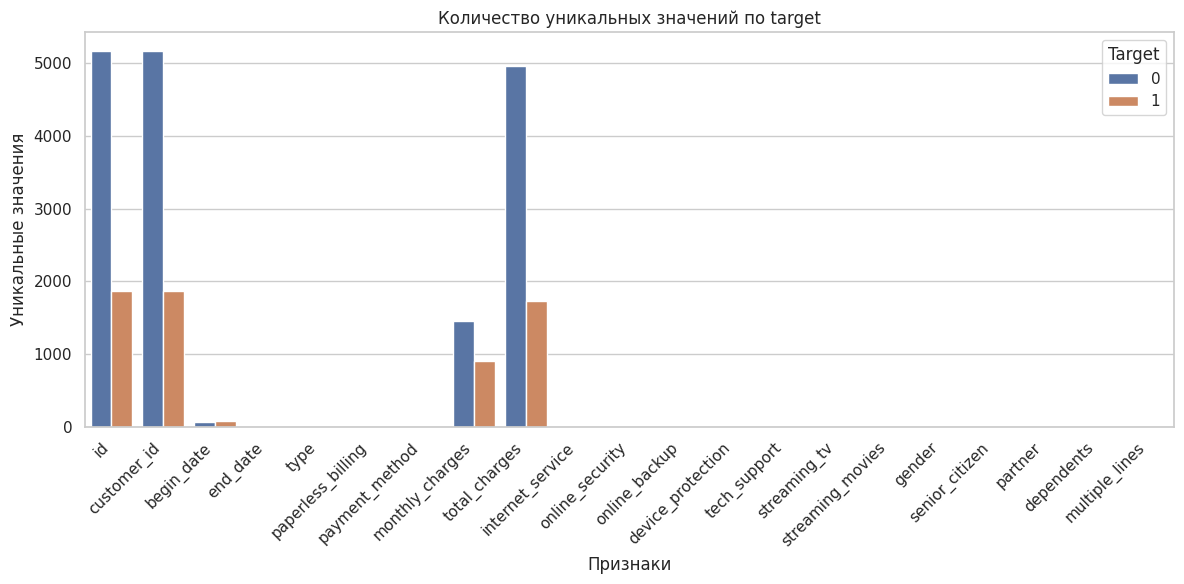

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=agg_df,
    x="Feature",
    y="Unique Values",
    hue="target"
)
plt.xticks(rotation=45, ha='right')
plt.title("Количество уникальных значений по target")
plt.ylabel("Уникальные значения")
plt.xlabel("Признаки")
plt.legend(title="Target", loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_4'))

/tmp/ipykernel_3106/2053322215.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Target", loc="upper right")


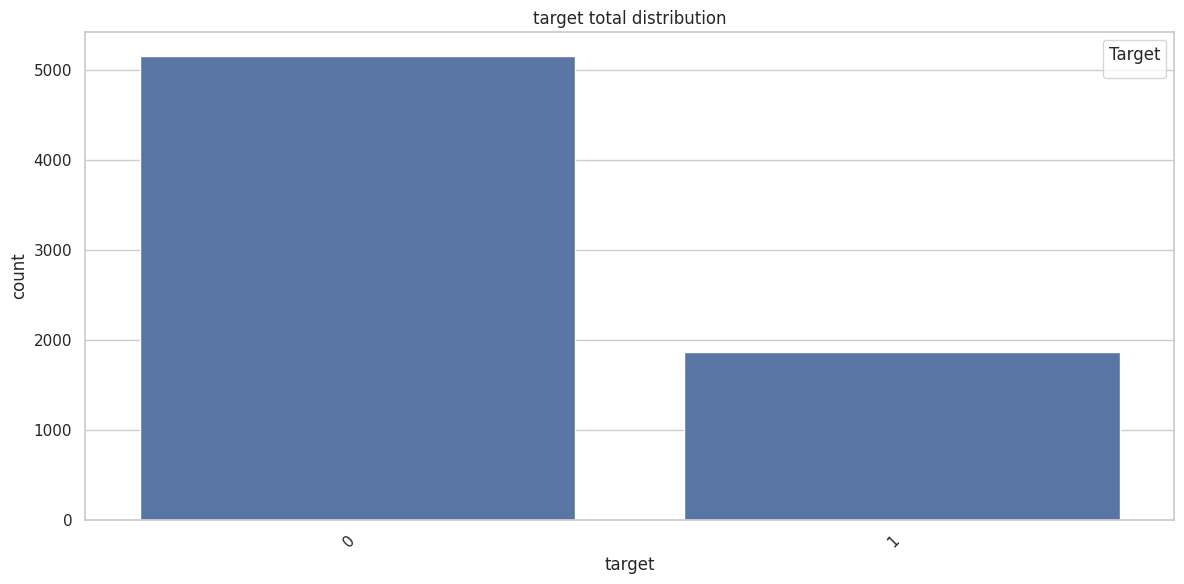

In [18]:
# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()

# создание столбчатой диаграммы для визуализации распределения целевой переменной
plt.figure(figsize=(12, 6))
sns.barplot(data=target_agg, x='target', y='count')
plt.xticks(rotation=45, ha='right')
plt.title(f"{x} total distribution")
plt.legend(title="Target", loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_5'))

In [19]:
x = "begin_date"
target = "target"
# определение статистики для агрегации
stat = ["count"]


In [20]:
target_agg_by_date = df[df[target]==1].groupby(x)[target].agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns
target_agg_by_date.columns = [x, "target_count"]

In [21]:
target_agg = df.groupby([x,target])['customer_id'].agg(stat).reset_index()
target_agg.columns = [x,target ,"target_customer_id"]

In [22]:
# расчёт суммы и количества для конверсии по датам
conversion_agg = df.groupby(x)[target].agg(['count','sum']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = conversion_agg['sum']/conversion_agg['count']

In [23]:
# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df.groupby([x,'gender'])[target].agg(['count','sum']).reset_index()
conversion_agg_gender["conv"] = conversion_agg_gender['sum']/conversion_agg_gender['count']

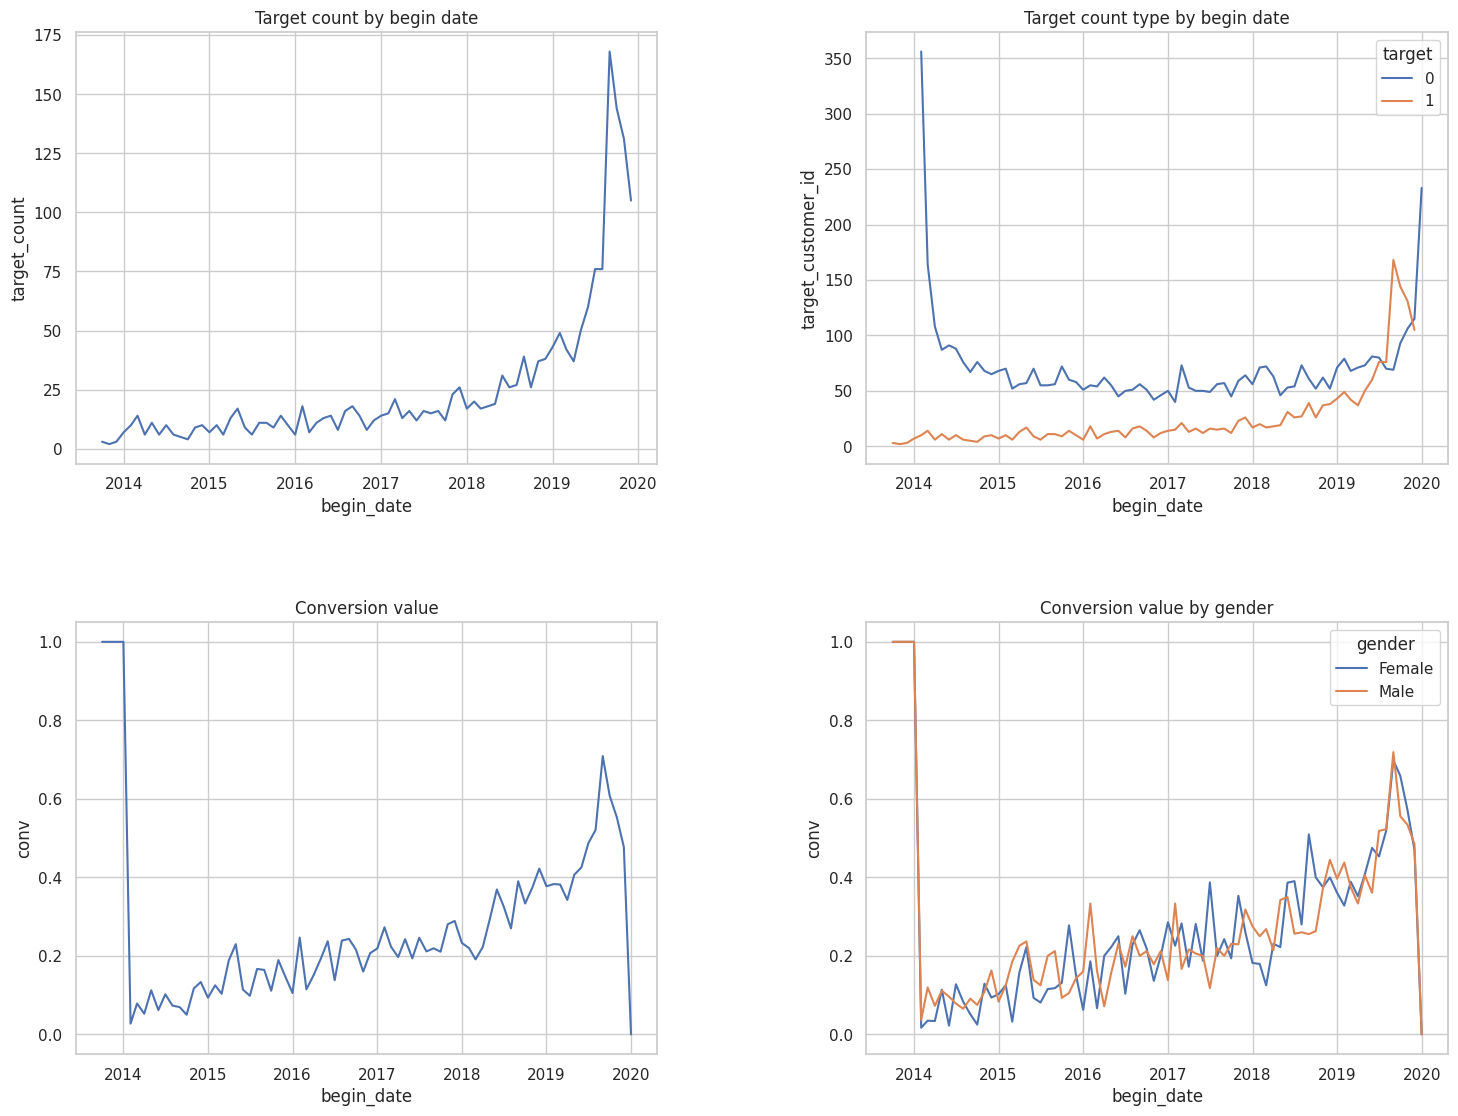

In [24]:
fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True) 

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")


# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="target_customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")


# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv",hue='gender' ,ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

In [25]:
charges = ["monthly_charges", "total_charges"]
target = "target"

<Axes: xlabel='monthly_charges', ylabel='Count'>

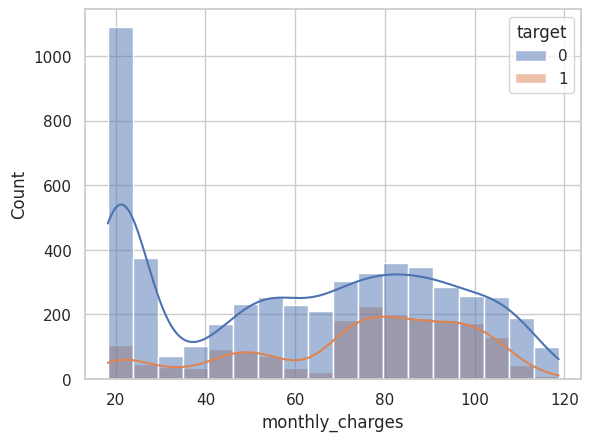

In [26]:
sns.histplot(data=df, x=charges[0],hue='target', kde=True)

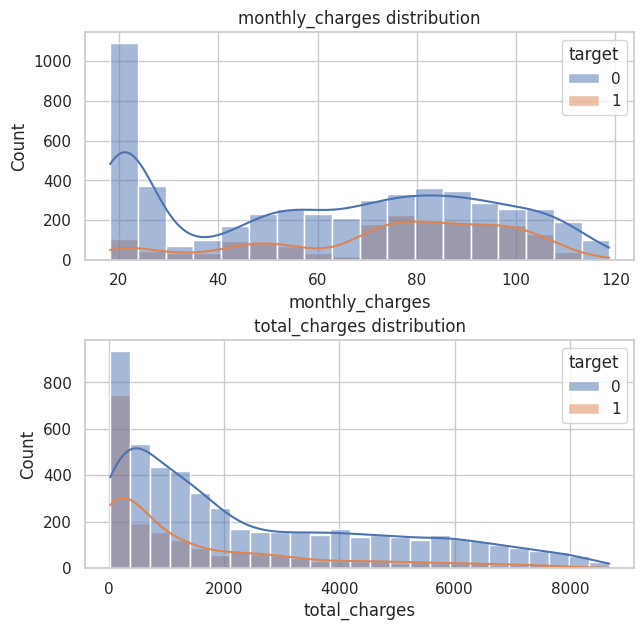

In [27]:
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

sns.histplot(data=df, x=charges[0],hue='target', kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")

sns.histplot(data=df, x=charges[1],hue='target', kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")

plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [41]:
ASSETS_DIR = 'assets'

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(ASSETS_DIR) 
    
print("Run ID:", run_id)

S3UploadFailedError: Failed to upload /home/mle-user/mle_projects/mle-mlflow/notebooks/assets/chargest_by_target_dist.png to s3-student-mle-20241125-59b9e9f709/4/624e73a884864b589247fecd30395ac6/artifacts/chargest_by_target_dist.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.

In [34]:
print(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

http://127.0.0.1:5000
